In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/gastonstat/CreditScoring/master/CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

In [4]:
status_vals = {
    1:'ok',
    2:'default',
    0:'unk'
    }

df.status = df.status.map(status_vals)

home_vals = {
    1:'rent',
    2:'owner',
    3:'private',
    4:'ignore',
    5:'parents',
    6:'other',
    0:'unk'
    }

df.home = df.home.map(home_vals)
marital_vals = {
    1:'single',
    2:'married',
    3:'widow',
    4:'separated',
    5:'divorced',
    0:'unk'
    }

df.marital = df.marital.map(marital_vals)
records_vals = {
    1:'no',
    2:'yes',
    0:'unk'
    }

df.records = df.records.map(records_vals)
job_vals = {
    1:'fixed',
    2:'parttime',
    3:'freelance',
    4:'others',
    0:'unk'
    }

df.job = df.job.map(job_vals)


In [5]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [6]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [7]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999.0, value=np.nan)

In [8]:
df = df[df.status!='unk']
df.status.value_counts()

status
ok         3200
default    1254
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2,random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25,random_state=11)


In [11]:
y_train = (df_train.status == 'default').astype(int)
y_test = (df_test.status == 'default').astype(int)
y_val = (df_val.status == 'default').astype(int)

In [12]:
del df_train['status']
del df_test['status']
del df_val['status']

### DTC


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer

In [14]:
train_dict = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [15]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [16]:
val_dict = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = dt.predict_proba(X_val)

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [18]:
roc_auc_score(y_val, y_pred[:,1])

0.6429457993267297

In [19]:
y_pred = dt.predict_proba(X_train)
roc_auc_score(y_train, y_pred[:,1])

1.0

In [20]:
######### OVERFITTING


In [33]:
def trainy(train_dict, y_train, depth, msl=1):
    X_train = dv.fit_transform(train_dict)
    dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=msl)
    dt.fit(X_train, y_train)
    return dt, dv

def predict(df_val, dt, dv):
    val_dict = df_val.fillna(0).to_dict(orient='records')
    X_val = dv.transform(val_dict)
    y_pred = dt.predict_proba(X_val)[:,1]
    return y_pred

#roc_auc_score(y_val, y_pred)

In [34]:
for x in range(4,7):
    dt,dv = trainy(train_dict, y_train, x)
    y_pred = predict(df_train,dt,dv)
    print(f'\n\n  train for {x}')
    print(roc_auc_score(y_train, y_pred))
    y_pred = predict(df_val,dt,dv)
    print(f'\n vlidation')
    print(roc_auc_score(y_val, y_pred))



  train for 4
0.8164293560926146

 vlidation
0.7612827250490422


  train for 5
0.8433781899611289

 vlidation
0.7669377103969388


  train for 6
0.8745461523294462

 vlidation
0.7541595020706691


In [35]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- seniority <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- seniority >  0.50
|   |   |   |   |--- income <= 50.50
|   |   |   |   |   |--- price <= 1250.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- price >  1250.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- income >  50.50
|   |   |   |   |   |--- home=rent <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- home=rent >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- amount <= 2175.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- amount >  2175.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   

In [24]:
########## END OF L3

In [25]:
##### L4
## missclassification error Impurity
### how much errors we make
### df.s.value_counts(normalize=True)

## for f in features
### for t in thresholds
#### split data using f>t
#### calc impurity
# select lowest impurity
# when to stop? => group already pure - reached depth limit - to small group(min size group)

In [ ]:
# min_samples_leaf

In [45]:
scores = []
for d in [4,5,6]:
    for msl in range(1,200):#[1,2,5,10,15,20,50,100,200,500]:
        dt,dv = trainy(train_dict, y_train, x, msl)
        y_pred = predict(df_train,dt,dv)
        print(f'train for depth:{d} msl:{msl}')
        #print(roc_auc_score(y_train, y_pred))
        y_pred = predict(df_val,dt,dv)
        #print(f'\n vlidation')
        scores.append([d,msl,roc_auc_score(y_val, y_pred)])
        #print(roc_auc_score(y_val, y_pred))



  train for depth:4 msl:1
0.8745461523294462

 vlidation
0.7544834225375989

  train for depth:4 msl:2
0.8735905723621206

 vlidation
0.7504026301130996

  train for depth:4 msl:3
0.8730796856515126

 vlidation
0.7541534474825022

  train for depth:4 msl:4
0.8715575883048843

 vlidation
0.7624452059770893

  train for depth:4 msl:5
0.8733733310799392

 vlidation
0.7623301688019181

  train for depth:4 msl:6
0.872475846431187

 vlidation
0.7637136421980577

  train for depth:4 msl:7
0.8715723762041575

 vlidation
0.7647459494805163

  train for depth:4 msl:8
0.8701513295025634

 vlidation
0.7691718534305295

  train for depth:4 msl:9
0.8674944369331306

 vlidation
0.7789076312029256

  train for depth:4 msl:10
0.86577904061743

 vlidation
0.7782991450921508

  train for depth:4 msl:11
0.8641597656470059

 vlidation
0.7812658932939383

  train for depth:4 msl:12
0.8629049067658161

 vlidation
0.7798733380155483

  train for depth:4 msl:13
0.8622725480254634

 vlidation
0.777687631687292

In [41]:
scores

[[4, 1, 0.750835533167034],
 [4, 2, 0.7539839190138287],
 [4, 5, 0.7622121043326633],
 [4, 10, 0.7782991450921508],
 [4, 20, 0.7739822237291418],
 [4, 50, 0.770288924947325],
 [4, 100, 0.7764343319367417],
 [4, 200, 0.7682666924995762],
 [4, 500, 0.679842459615897],
 [5, 1, 0.7559244145213243],
 [5, 2, 0.7546014870068538],
 [5, 5, 0.7602897725896685],
 [5, 10, 0.7782991450921508],
 [5, 20, 0.7739822237291418],
 [5, 50, 0.7717329442251338],
 [5, 100, 0.7764343319367417],
 [5, 200, 0.7682666924995762],
 [5, 500, 0.679842459615897],
 [6, 1, 0.7574622799157201],
 [6, 2, 0.7633897217311278],
 [6, 5, 0.7616581095153908],
 [6, 10, 0.7775211305127026],
 [6, 20, 0.7742788985493206],
 [6, 50, 0.7717329442251338],
 [6, 100, 0.7764343319367417],
 [6, 200, 0.7682666924995762],
 [6, 500, 0.679842459615897]]

In [46]:
df1 = pd.DataFrame(scores, columns=['depth', 'msl', 'score'])

In [47]:
df1.sort_values(by='score', ascending=False)

,depth,msl,score
413,6,16,0.791350
214,5,16,0.790980
15,4,16,0.790980
72,4,73,0.787320
271,5,73,0.787320
...,...,...,...
0,4,1,0.754483
2,4,3,0.754153
400,6,3,0.752361
201,5,3,0.750817


In [53]:
dfpv = df1.pivot(index='msl', columns=['depth'], values=['score']).head()

In [55]:
dfpv

score                    
depth         4         5         6
msl                                
1      0.754483  0.759563  0.761949
2      0.750403  0.762527  0.759960
3      0.754153  0.750817  0.752361
4      0.762445  0.763478  0.761828
5      0.762330  0.759636  0.759321

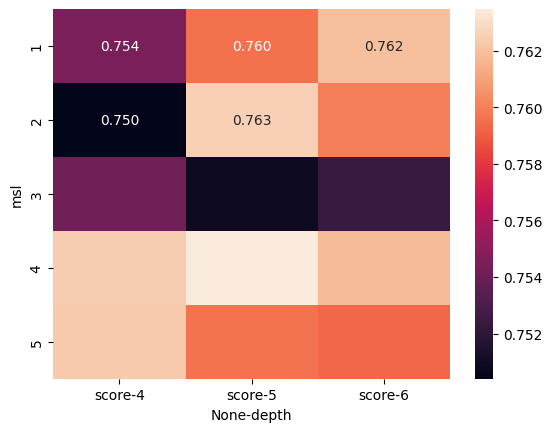

In [65]:
sns.heatmap(dfpv, annot=True, fmt='.3f');

In [66]:
##############################################################################################################
################################################ RANDOM FPREST ###############################################

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [74]:
y_pred = rf.predict_proba(X_val)[:,1]

In [75]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [77]:
for x in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=x, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:,1]
    print(f'{x} : {roc_auc_score(y_val, y_pred)}')

10 : 0.7744726453706618
20 : 0.8035316412777603
30 : 0.8150747136179797
40 : 0.8156862270228379
50 : 0.8170818095953114
60 : 0.8164581870141193
70 : 0.8173209658279045
80 : 0.8163068223099464
90 : 0.8168244895982175
100 : 0.8175994768835824
110 : 0.8175268218255793
120 : 0.8179385338209295
130 : 0.8182533724056089
140 : 0.818102007701436
150 : 0.8172695018284857
160 : 0.8179809159380979
170 : 0.8176055314717492
180 : 0.8174632486498269
190 : 0.817980915938098
200 : 0.8190495507495582


In [87]:
scores = []

for d in range(7,13,1):
    for x in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=x,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:,1]
        score = roc_auc_score(y_val, y_pred)
        scores.append([d, x, score])
        #print(f'{x} : {score}')

In [88]:
columns = ['depth', 'n_trees', 'score']
dfrf = pd.DataFrame(scores, columns=columns)

In [ ]:
dfrf.sort_values(by='score', ascending=False)

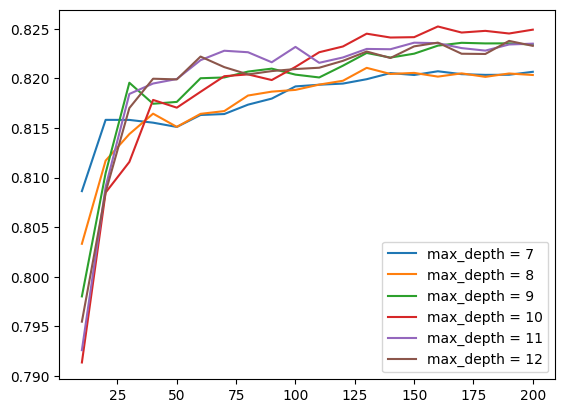

In [90]:
for d in range(7,13,1):
    dfsub = dfrf[dfrf.depth==d]
    plt.plot(dfsub.n_trees, dfsub.score, label=f'max_depth = {d}')
plt.legend()

In [110]:
scores = []
max_depth = 10

for s in [1,3,5,10,30,50]:
    for x in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=x,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:,1]
        score = roc_auc_score(y_val, y_pred)
        scores.append([s, x, score])
        #print(f'{x} : {score}')

In [94]:
columns = ['msl', 'n_trees', 'score']
dfrfs = pd.DataFrame(scores, columns=columns)

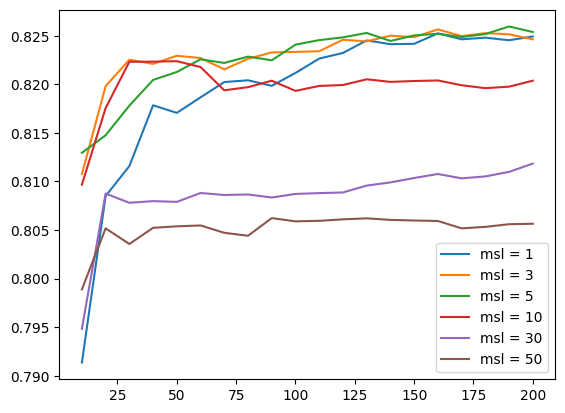

In [98]:
for s in [1,3,5,10,30,50]:
    dfsub = dfrfs[dfrfs.msl==s]
    plt.plot(dfsub.n_trees, dfsub.score, label=f'msl = {s}')
plt.legend()

In [103]:
from IPython.display import display

In [107]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 4,
                       ):
    print(dfrfs[dfrfs.msl==3].sort_values(by='score', ascending=False))


    msl  n_trees   score
35    3      160  0.8257
37    3      180  0.8253
38    3      190  0.8251
33    3      140  0.8250
36    3      170  0.8250
34    3      150  0.8248
39    3      200  0.8246
31    3      120  0.8246
32    3      130  0.8244
30    3      110  0.8234
29    3      100  0.8233
28    3       90  0.8233
24    3       50  0.8229
25    3       60  0.8227
27    3       80  0.8226
22    3       30  0.8225
23    3       40  0.8221
26    3       70  0.8215
21    3       20  0.8198
20    3       10  0.8108


In [109]:
msl = 3
max_depth = 10
n = 140

rf = RandomForestClassifier(n_estimators=n,
                            max_depth=max_depth,
                            min_samples_leaf=s,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=50, n_estimators=140,
                       random_state=1)

In [ ]:
################################################################################################################
#################################################### XGBOOST ###################################################

In [111]:
import xgboost as xgb

In [118]:
list(dv.get_feature_names_out())

['age',
 'amount',
 'assets',
 'debt',
 'expenses',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=parttime',
 'job=unk',
 'marital=divorced',
 'marital=married',
 'marital=separated',
 'marital=single',
 'marital=unk',
 'marital=widow',
 'price',
 'records=no',
 'records=yes',
 'seniority',
 'time']

In [119]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, y_train, feature_names=features)
dval = xgb.DMatrix(X_val, y_val, feature_names=features)

In [123]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [124]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8065256351262986

In [125]:
watchlist = [(dtrain,'train'), (dval,'val')]

In [133]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals = watchlist,
                  verbose_eval = 5,
                  num_boost_round=100)

In [ ]:
output = output.stdout


In [164]:
scores = []

def pars_xgb_op(op):
    dfxgb = pd.DataFrame(columns=['iter', 'trnScore', 'valScore'])
    output = op.split('\n')
    for n in output:
        if not n:
            continue
        niter, trainauc, valauc = n.split('\t')
        scores.append([int(niter.strip('[]')), float(trainauc.split(':')[1]),float(valauc.split(':')[1])])
    dfxgb = pd.DataFrame(scores, columns=['iter', 'trnScore', 'valScore'])
    return dfxgb

In [165]:
dfxgb = pars_xgb_op(output)

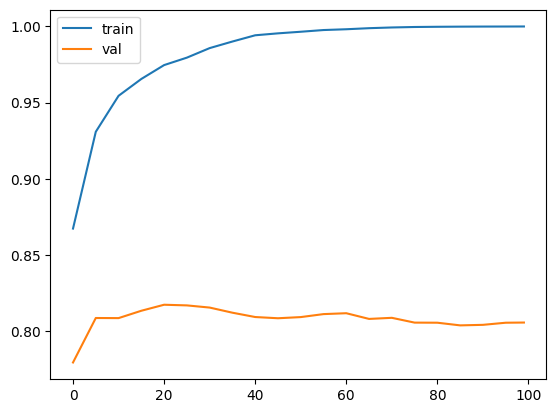

In [167]:
plt.plot(dfxgb.iter, dfxgb.trnScore, label='train')
plt.plot(dfxgb.iter, dfxgb.valScore, label='val')
plt.legend()

In [166]:
dfxgb

,iter,trnScore,valScore
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729
5,25,0.97953,0.81686
6,30,0.98579,0.81543
7,35,0.99011,0.81206
8,40,0.99421,0.80922
9,45,0.99548,0.80842
